Import libraries and data

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection  import train_test_split 
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster, metrics

In [2]:
crime_data = pd.read_csv('crime_data/man_cr_med.csv').set_index('lsoa')
all_data = pd.read_csv('data/manchester_data.csv').set_index('GEO_CODE').join(crime_data, how='left')

la_data = pd.read_csv('shapefiles/manlsoala.csv').set_index('geo_code')
lsoa_data = gpd.read_file('shapefiles/man_lsoa_all.shp').set_index('geo_code').join(la_data, how = 'left')

In [3]:
all_data.loc[all_data.vi_crime_count.isnull(), 'vi_crime_count'] = all_data['vi_crime_count'].median()

In [4]:
all_data.head()

,age_mean,age_median,badhealth,centheat,nodepr,depr_4+,depr_3+,depr_2+,studenthhold,onefam_hhold,nocars,eth_hhi,ethwhite,vi_crime_count
GEO_CODE,,,,,,,,,,,,,,
E01004766,42.10929,42.0,0.075377,0.937107,0.350943,0.002516,0.051572,0.298113,0.001258,0.510692,0.354717,0.176145,0.863693,31.0
E01004767,40.15316,39.0,0.048868,0.958333,0.446615,0.003906,0.046875,0.221354,0.010417,0.558594,0.244792,0.172369,0.796782,39.0
E01004768,39.94941,42.0,0.016864,0.991736,0.641322,0.000000,0.008264,0.084298,0.000000,0.796694,0.044628,0.221215,0.937539,7.0
E01004769,41.63690,42.5,0.035202,0.982482,0.554745,0.001460,0.016058,0.138686,0.000000,0.645255,0.132847,0.197436,0.930248,17.0
E01004770,44.31058,45.0,0.055290,0.978896,0.452922,0.001623,0.022727,0.194805,0.000000,0.733766,0.144481,0.136553,0.822526,13.0


### Preprocess data

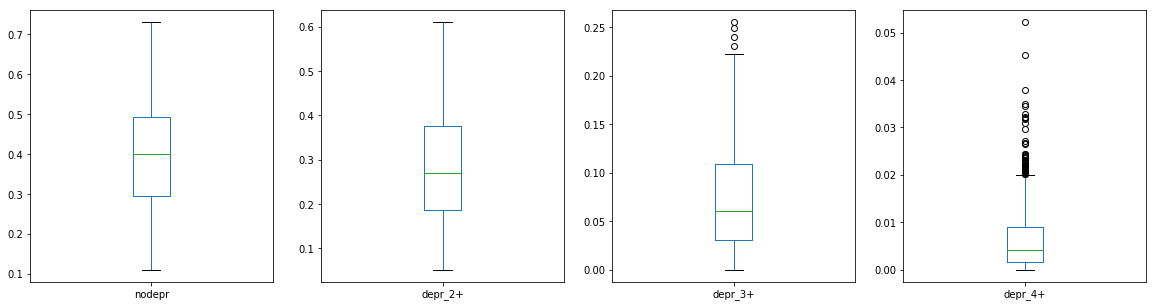

In [5]:
all_data[['nodepr', 'depr_2+', 'depr_3+', 'depr_4+']].plot(kind='box', subplots=True, figsize=(20, 5))
plt.show()

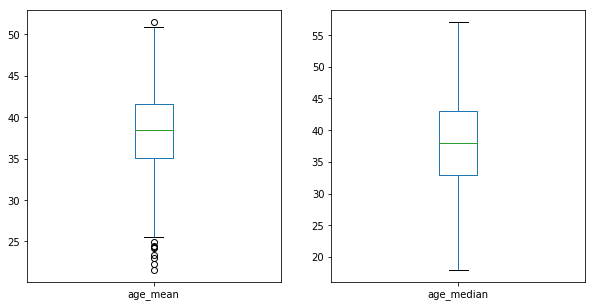

In [6]:
all_data[['age_mean', 'age_median']].plot(kind='box', subplots=True, figsize=(10, 5))
plt.show()

In [51]:
to_keep = ['age_median', 'badhealth', 'studenthhold', 'onefam_hhold', 'eth_hhi', 'depr_2+', 'nocars']
to_keep_z = ['vi_crime_count']

for variable in to_keep:
    var_z = variable + '_z'
    to_keep_z.append(var_z)
    all_data[var_z] = (all_data[variable] - all_data[variable].mean())/all_data[variable].std(ddof=0)

for variable in to_keep_z:
    all_data[variable] = all_data[variable].fillna(all_data[variable].median())

In [52]:
all_data[to_keep_z].head()

,vi_crime_count,age_median_z,badhealth_z,studenthhold_z,onefam_hhold_z,eth_hhi_z,depr_2+_z,nocars_z
GEO_CODE,,,,,,,,
E01004766,31.0,0.630702,0.284958,-0.161325,-0.855892,-0.031264,0.130367,0.360701
E01004767,39.0,0.172698,-0.652414,0.115203,-0.440988,-0.080929,-0.522746,-0.309699
E01004768,7.0,0.630702,-1.784057,-0.199303,1.621328,0.561534,-1.688907,-1.530434
E01004769,17.0,0.707036,-1.135634,-0.199303,0.309636,0.248769,-1.226136,-0.992417
E01004770,13.0,1.088706,-0.425316,-0.199303,1.076275,-0.552008,-0.748641,-0.921466


In [53]:
# join df
spatial_data = lsoa_data.join(all_data[to_keep_z], how = 'right')

In [ ]:
# fill nan with 0, so that it can be mapped --> check if there is reason to assume that nan means there was no crime
# spatial_data.loc[spatial_data.vi_crime_count.isnull(), 'vi_crime_count'] = 0

In [54]:
# do median split for violent crime count
spatial_data['crime_med'] = 'Below Median'
spatial_data.loc[spatial_data.vi_crime_count >= spatial_data.vi_crime_count.median(), 'crime_med'] = 'Above Median'

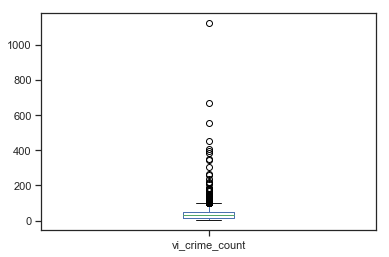

In [55]:
spatial_data['vi_crime_count'].plot(kind='box')

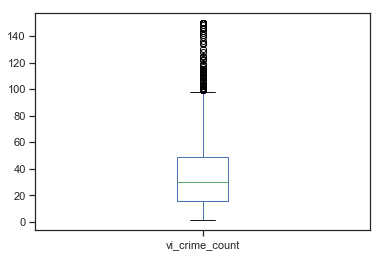

In [56]:
spatial_data.loc[spatial_data.vi_crime_count > 150, 'vi_crime_count'] = 150
spatial_data['vi_crime_count'].plot(kind='box')

Text(0.5, 1.0, "Median Split of 'Violence and Sexual Offence' Crime Count across Manchester LSOAs")

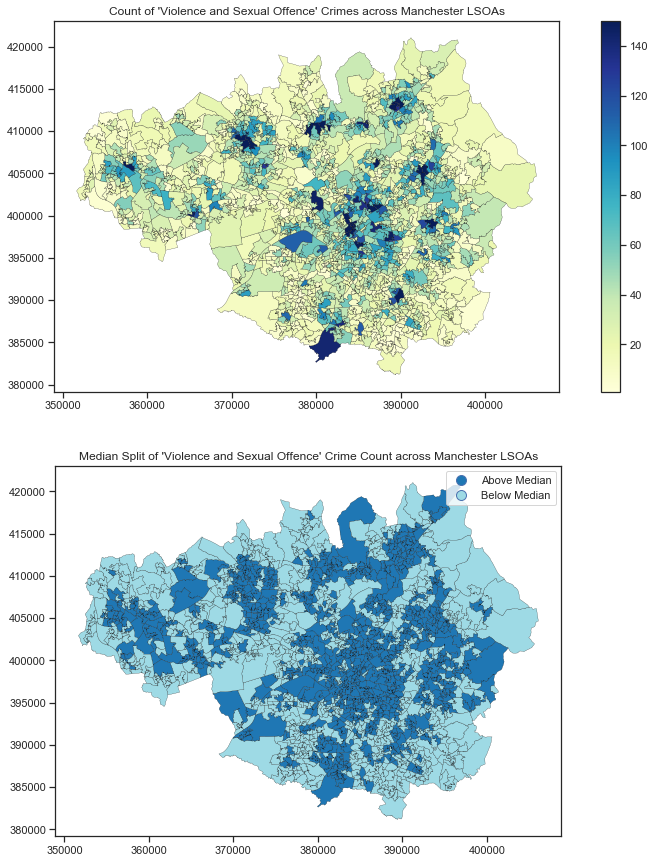

In [57]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

# Count map
spatial_data.plot(ax=ax1,
                  column='vi_crime_count', 
                  cmap='YlGnBu',
                  linewidth=0.2, edgecolor='black',
                  legend=True
                 )\
            .set_title("Count of 'Violence and Sexual Offence' Crimes across Manchester LSOAs")

# Median split map
spatial_data.plot(ax=ax2,
                  column='crime_med', 
                  cmap='tab20',
                  linewidth=0.2, edgecolor='black', 
                  legend=True
                 )\
            .set_title("Median Split of 'Violence and Sexual Offence' Crime Count across Manchester LSOAs")

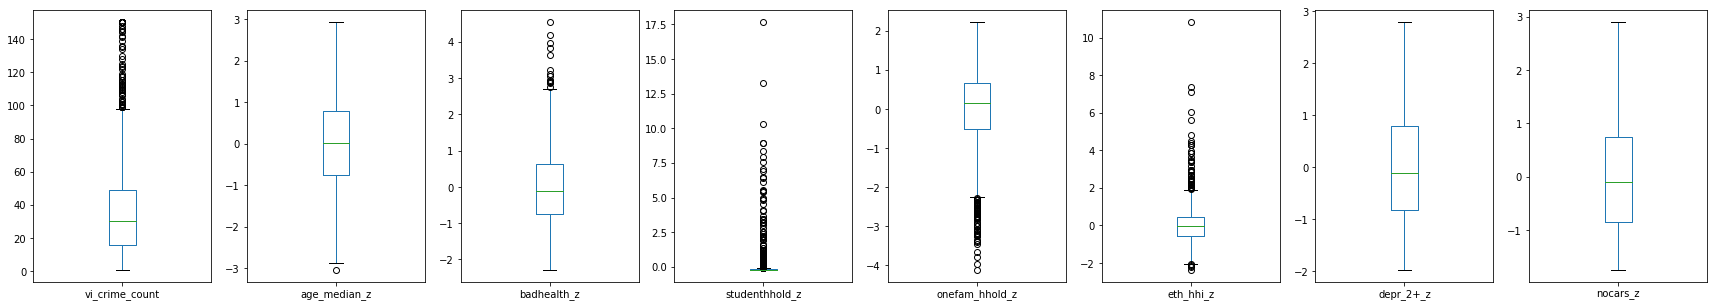

In [14]:
# box plots
spatial_data[to_keep_z].plot(kind='box', subplots=True, figsize=(30, 5))
plt.show()

In [15]:
# too many 0's so do not log transfrom 
len(spatial_data['studenthhold_z'].value_counts(0))

435

In [16]:
to_keep = ['crime_med', 'age_median_z', 'badhealth_z', 'onefam_hhold_z', 'eth_hhi_z', 'depr_2+_z', 'nocars_z'] #'studenthhold_z']
man_data = spatial_data[to_keep].dropna(axis = 0)

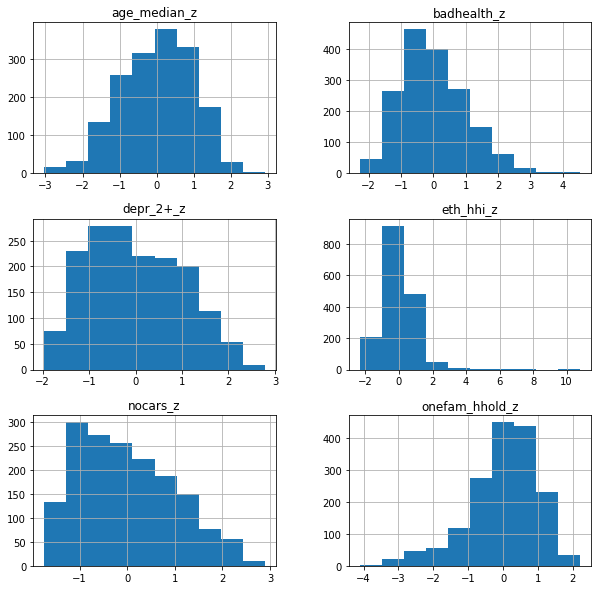

In [17]:
man_data.hist(figsize=(10, 10))
plt.show()

In [18]:
man_data.describe().loc[['mean', 'std'], :]

,age_median_z,badhealth_z,onefam_hhold_z,eth_hhi_z,depr_2+_z,nocars_z
mean,-1.359078e-16,-7.644811e-17,4.247117e-17,1.019308e-16,3.397694e-16,1.868732e-16
std,1.000299e+00,1.000299e+00,1.000299e+00,1.000299e+00,1.000299e+00,1.000299e+00


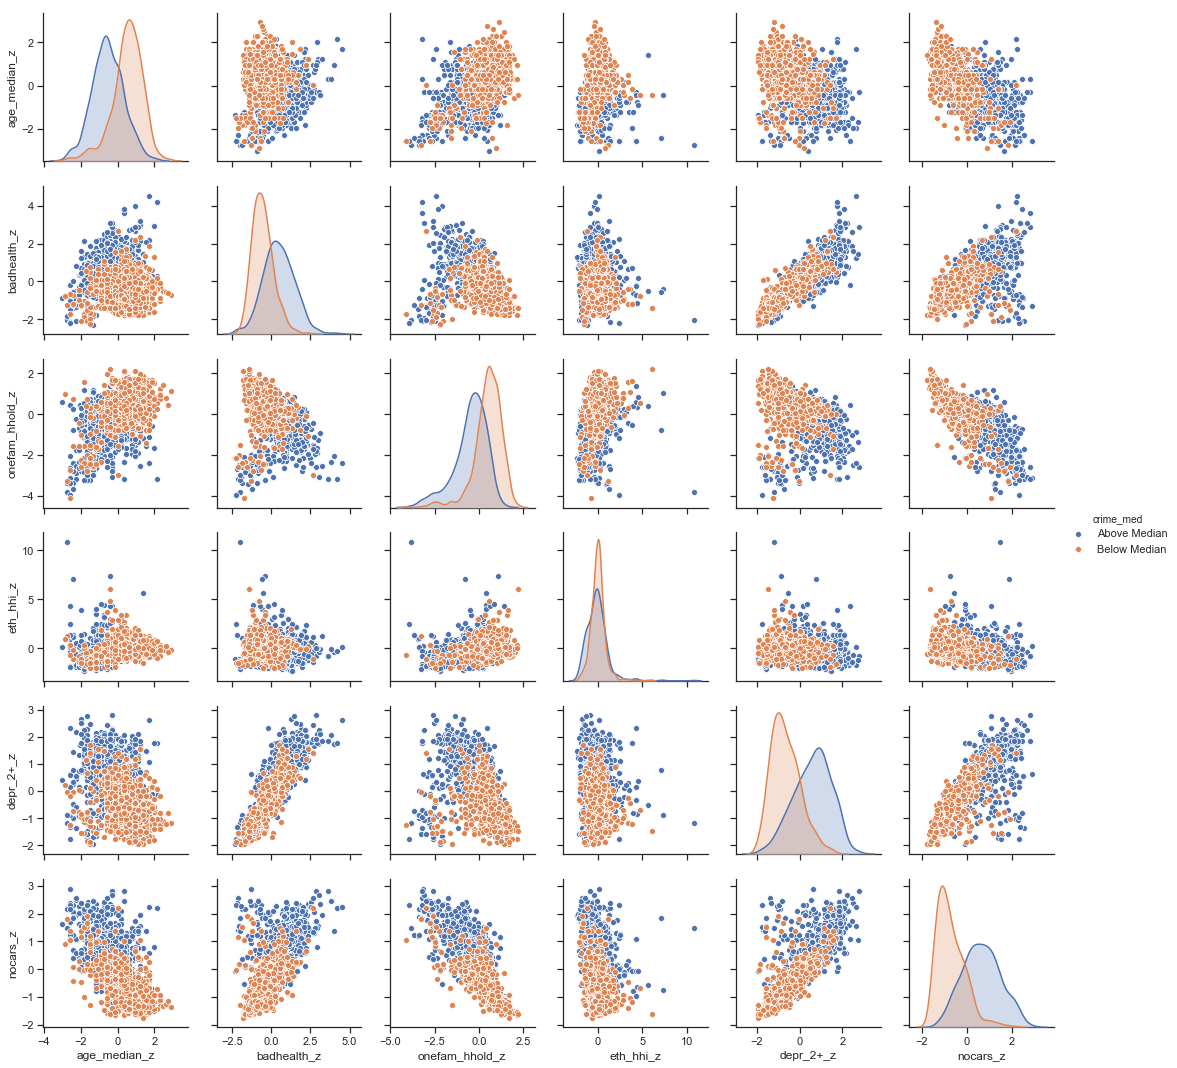

In [19]:
sns.set(style="ticks")
sns.pairplot(man_data, hue = 'crime_med')

In [20]:
man_data.corr()

,age_median_z,badhealth_z,onefam_hhold_z,eth_hhi_z,depr_2+_z,nocars_z
age_median_z,1.000000,-0.141405,0.528518,0.176648,-0.436927,-0.660278
badhealth_z,-0.141405,1.000000,-0.400380,-0.077726,0.883362,0.673749
onefam_hhold_z,0.528518,-0.400380,1.000000,0.268577,-0.464719,-0.797974
eth_hhi_z,0.176648,-0.077726,0.268577,1.000000,-0.143013,-0.250905
depr_2+_z,-0.436927,0.883362,-0.464719,-0.143013,1.000000,0.815537
nocars_z,-0.660278,0.673749,-0.797974,-0.250905,0.815537,1.000000


### K-Means from Liverpool practical

In [21]:
km2 = cluster.KMeans(n_clusters=2)

np.random.seed(1234)
k2cls = km2.fit(man_data.drop('crime_med', axis = 1))

k2cls.labels_

array([0, 1, 1, ..., 0, 0, 0])

In [22]:
man_data.groupby(k2cls.labels_)\
        .size()

# should be equal in size because of median split

0    780
1    893
dtype: int64

In [23]:
man_data.groupby(k2cls.labels_)\
        .mean()\
        .T

,0,1
age_median_z,-0.662767,0.578901
badhealth_z,0.665219,-0.581042
onefam_hhold_z,-0.675635,0.590140
eth_hhi_z,-0.264639,0.231152
depr_2+_z,0.809373,-0.706955
nocars_z,0.884622,-0.772682


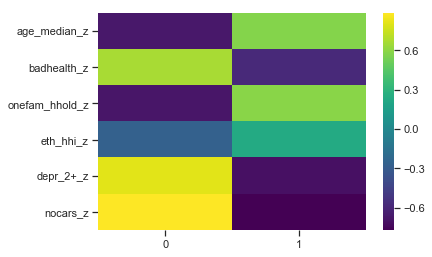

In [24]:
sns.heatmap(man_data.groupby(k2cls.labels_)\
                    .mean()\
            .T,
            cmap='viridis');

In [25]:
cluster_data = man_data.reset_index()[['GEO_CODE', 'crime_med']].join(pd.Series(k2cls.labels_, name='cluster'))

cluster_data.loc[cluster_data.cluster < 0.5, 'cluster_lab'] = 'Cluster 1'
cluster_data.loc[cluster_data.cluster > 0.5, 'cluster_lab'] = 'Cluster 2'

In [26]:
cluster_2 = cluster_data[['GEO_CODE', 'cluster_lab']].set_index('GEO_CODE')

In [27]:
# Tidy up!
tidy = man_data.drop('crime_med', axis = 1)\
                .stack()\
                .reset_index()\
                .rename(columns={0: 'value','level_1': 'var'})\
                .set_index('GEO_CODE')\
                .join(cluster_2)
tidy.head()

,var,value,cluster_lab
GEO_CODE,,,
E01004766,age_median_z,0.630702,Cluster 1
E01004766,badhealth_z,0.284958,Cluster 1
E01004766,onefam_hhold_z,-0.855892,Cluster 1
E01004766,eth_hhi_z,-0.031264,Cluster 1
E01004766,depr_2+_z,0.130367,Cluster 1


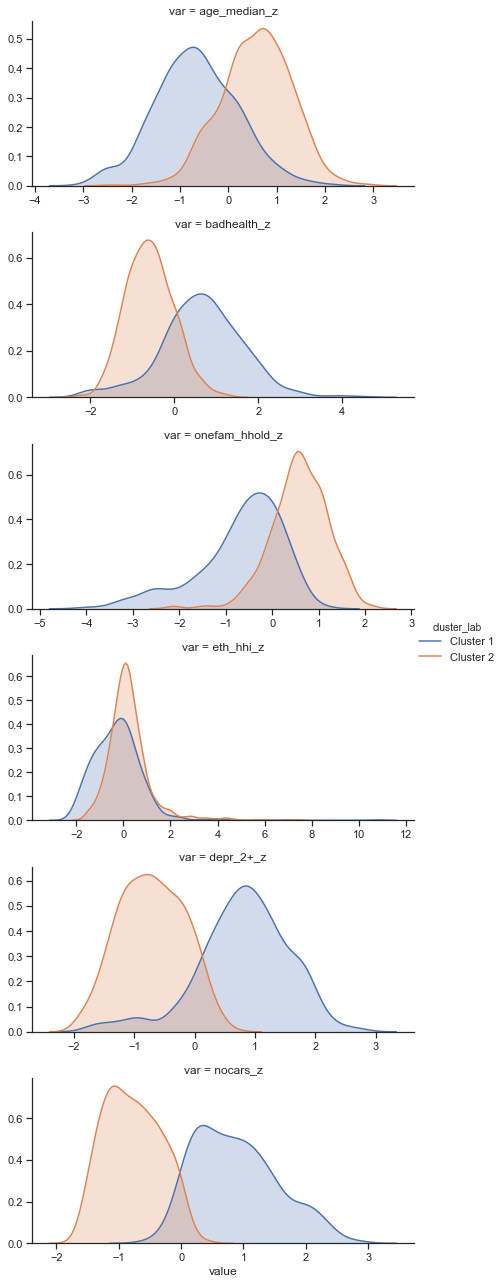

In [28]:
g = sns.FacetGrid(row='var', hue='cluster_lab', data=tidy,
                  sharey=False, sharex=False, aspect=2)
g.map(sns.kdeplot, 'value', shade=True).add_legend();

Text(0.5, 1.0, 'Actual Distribution')

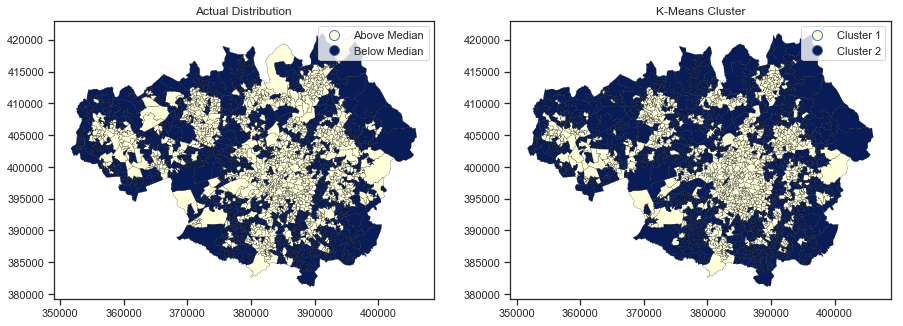

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

# K-Means Map
spatial_data.join(cluster_2, how = 'right')\
            .plot(ax = ax2,
                  column='cluster_lab', 
                  cmap='YlGnBu',
                  linewidth=0.2, edgecolor='black',
                  legend=True
            )\
            .set_title("K-Means Cluster")


# Median split map
spatial_data.plot(ax=ax1,
                  column='crime_med', 
                  cmap='YlGnBu',
                  linewidth=0.2, edgecolor='black', 
                  legend=True
                 )\
            .set_title("Actual Distribution")

In [30]:
# show crosstab to see how many were correct / incorrect
pd.crosstab(cluster_data.crime_med, cluster_data.cluster_lab)

cluster_lab,Cluster 1,Cluster 2
crime_med,,
Above Median,660,197
Below Median,120,696


In [31]:
crosstab = pd.crosstab(cluster_data.crime_med, cluster_data.cluster_lab).apply(lambda r: r/len(cluster_data) * 100, axis=1)
print('Accuracy:', (crosstab.loc['Above Median']['Cluster 1'] + crosstab.loc['Below Median']['Cluster 2']))

Accuracy: 81.05200239091452


## PCA

In [32]:
# Perform PCA
pca = PCA(n_components=None) # Create an instance of the PCA class

# Fit the data to the model
pcaResults = pca.fit_transform(man_data.iloc[:,1:]) # Remove crime_med for the pca
explained_variance = pca.explained_variance_ratio_ # Extract the varience

In [33]:
# Show how much variance each PC explains
print(np.around(explained_variance, 3))

[0.574 0.186 0.141 0.077 0.013 0.008]


### Using 2 components

In [34]:
# Perform PCA using 2 components
pca = PCA(n_components = 2).fit_transform(man_data.iloc[:,1:])

In [35]:
# perform k-means on pca (using 2 clusters)
k_pca = cluster.KMeans(n_clusters=2).fit(pca)

In [36]:
colour_map = {
    'Above Median': 'blue',
    'Below Median' : 'orange',
    1 : 'blue',
    0 : 'orange',
}

# Create an array of colours based on the target column
org_colours = [colour_map[c] for c in man_data['crime_med']]
pca_colours = [colour_map[c] for c in k_pca.labels_]
raw_colours = [colour_map[c] for c in (1 - k2cls.labels_)] # inverted, so use 1-k2cls.labels_

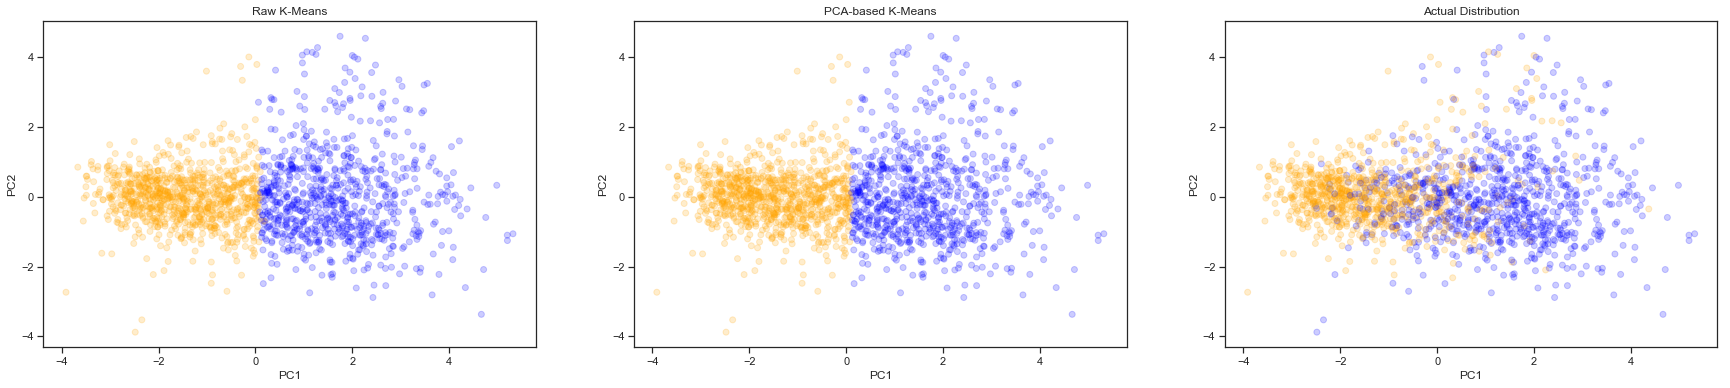

In [39]:
# k=2 as the original clustering
k_pca = cluster.KMeans(n_clusters=2).fit(pca)

f, axs = plt.subplots(1, 3, figsize=(30, 6))

axs[0].scatter(pca[:, 0], pca[:, 1], 
               c=raw_colours,
               alpha=0.2);
axs[0].set_title('Raw K-Means')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')

axs[1].scatter(pca[:, 0], pca[:, 1], 
               c=pca_colours,
               alpha=0.2);
axs[1].set_title('PCA-based K-Means')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')

axs[2].scatter(pca[:, 0], pca[:, 1], 
               c=org_colours,
               alpha=0.2);
axs[2].set_title('Actual Distribution')
axs[2].set_xlabel('PC1')
axs[2].set_ylabel('PC2')

plt.show()

In [40]:
# check difference between raw and pca-based clusters
sum(((1 - k2cls.labels_) - k_pca.labels_) * ((1 - k2cls.labels_) - k_pca.labels_))

8

### Using 3 components

In [ ]:
'''# Perform PCA using 3 components
pca = PCA(n_components=3)
results = pca.fit_transform(man_data.iloc[:,1:])'''

In [ ]:
'''colour_map = {
    'Above Median': 'blue',
    'Below Median' : 'orange',
    1 : 'blue',
    0 : 'orange',
}

# Create an array of colours based on the target column
org_colours = [colour_map[c] for c in man_data['crime_med']]
pca_colours = [colour_map[c] for c in k_pca.labels_]
raw_colours = [colour_map[c] for c in k2cls.labels_]'''

In [ ]:
'''# PCA original colours
fig2 = plt.figure()
ax2 = Axes3D(fig2)
ax2.scatter(results[:, 0], results[:, 1], results[:, 2],  
            c=colours, alpha=0.2);
ax2.set_title('PCA-based original results')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')


# PCA-based K-means
fig1 = plt.figure()
ax1 = Axes3D(fig1)
ax1.scatter(results[:, 0], results[:, 1], results[:, 2], 
            c=pca_colours, cmap='RdBu', alpha=0.2);
ax1.set_title('PCA-based K-Means')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')


# Raw K-Means
fig1 = plt.figure()
ax1 = Axes3D(fig1)
ax1.scatter(results[:, 0], results[:, 1], results[:, 2], 
            c=raw_colours, alpha=0.2);
ax1.set_title('Non-PCA K-Means')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')'''

## PCA Evaluation

In [41]:
# Comparing solutions

chs_raw = metrics.calinski_harabaz_score(man_data.iloc[:,1:], k2cls.labels_)
chs_pca = metrics.calinski_harabaz_score(man_data.iloc[:,1:], k_pca.labels_)

pd.Series({'0-CHS-Raw': chs_raw,
           '1-CHS-PCA': chs_pca})

# Higher CHS for raw, but very similar. So raw analysis was good (relative to pca)


0-CHS-Raw    1182.004871
1-CHS-PCA    1181.529405
dtype: float64

# Regression

In [42]:
man_data.head()

,crime_med,age_median_z,badhealth_z,onefam_hhold_z,eth_hhi_z,depr_2+_z,nocars_z
GEO_CODE,,,,,,,
E01004766,Above Median,0.630702,0.284958,-0.855892,-0.031264,0.130367,0.360701
E01004767,Above Median,0.172698,-0.652414,-0.440988,-0.080929,-0.522746,-0.309699
E01004768,Below Median,0.630702,-1.784057,1.621328,0.561534,-1.688907,-1.530434
E01004769,Below Median,0.707036,-1.135634,0.309636,0.248769,-1.226136,-0.992417
E01004770,Below Median,1.088706,-0.425316,1.076275,-0.552008,-0.748641,-0.921466


In [43]:
#Reference Variable
man_data['_intercept'] = 1 # if all variables == 0

In [44]:
# Create Dummy Variables
dummy_df = pd.get_dummies(man_data.crime_med, prefix='crime_med')
man_data = man_data.join(dummy_df).rename(columns = {'crime_med_Above Median':'crime_med_above'})
man_data = man_data.drop(['crime_med', 'crime_med_Below Median'], axis=1)

# View Results
man_data.head()

,age_median_z,badhealth_z,onefam_hhold_z,eth_hhi_z,depr_2+_z,nocars_z,_intercept,crime_med_above
GEO_CODE,,,,,,,,
E01004766,0.630702,0.284958,-0.855892,-0.031264,0.130367,0.360701,1,1
E01004767,0.172698,-0.652414,-0.440988,-0.080929,-0.522746,-0.309699,1,1
E01004768,0.630702,-1.784057,1.621328,0.561534,-1.688907,-1.530434,1,0
E01004769,0.707036,-1.135634,0.309636,0.248769,-1.226136,-0.992417,1,0
E01004770,1.088706,-0.425316,1.076275,-0.552008,-0.748641,-0.921466,1,0


In [45]:
# import the dataset
x = man_data.iloc[:, :-2] # predictors
y = man_data.iloc[:,-1] # result 

# split the dataset into the training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=1234)

In [46]:
# Make the model
logit = sm.Logit(y_train, x_train)

# Fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\statsmodels\discrete\discrete_model.py:1724: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [47]:
# View the results
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:        crime_med_above   No. Observations:                 1338
Model:                          Logit   Df Residuals:                     1332
Method:                           MLE   Df Model:                            5
Date:                Mon, 11 Mar 2019   Pseudo R-squ.:                     inf
Time:                        16:33:07   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                     1.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
age_median_z      -0.8010      0.138     -5.824      0.000      -1.071      -0.531
badhealth_z        0.4682      0.236      1.986      0.047       0.006       0.930
onefam_hhold_z     0.0796      0.180

C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [48]:
# Get the predicted values from the test set
y_pred = result.predict(x_test)

In [49]:
# print confusion matrix
from sklearn.metrics import *
print(confusion_matrix(y_test, np.round(y_pred,0)))

[[140  25]
 [ 26 144]]


In [50]:
# Accuracy %
from sklearn.metrics import *
accuracy_score(y_test, np.round(y_pred,0))

0.8477611940298507